# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

52588


# 1. Pre-processing info

In [2]:
fov_param = {'data_folder':[r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304',
                            r'\\10.245.74.212\Chromatin_NAS_2\20220316-P_brain_CTP11-12-13_from_0304'],
             'save_folder':r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304',
             'experiment_type': 'DNA',
             'num_threads': 32,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

## 1.1 define required floders

In [76]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


34 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder


In [77]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

In [78]:
save_fov_ids = save_fov_ids[:-2]
save_filenames = save_filenames[:-2]

# 2. Partiton spots into cells

## 2.1 (For DNA-only) run segmentation

## (For DNA after dense MERFISH)

In [79]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220304-P_brain_M1_nonclear_adaptors\CellPoseSegment\features'
merfish_dapi_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation_Cellpose'
if not os.path.exists(merfish_dapi_folder):
    os.makedirs(merfish_dapi_folder)
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'][0], 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99997433 -0.00716481]
 [ 0.00716481  0.99997433]],
 translation:[-238.54348979 -722.53301093]
-- rotation matrix saved to file:\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\translation


## save DAPI image for RNA

In [80]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [81]:
overwrite_dapi = False
for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _im = ia.visual_tools.DaxReader(os.path.join(ref_fd, rna_fovs[_fov_id])).loadAll()
        _dapi_im = _im[4::5]
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [06:22<00:00, 11.95s/it]


In [82]:
import multiprocessing as mp
# savefile for segmentations
_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [83]:
# initiate locks
_manager = mp.Manager()
# savefile lock
_segmentation_savefile_lock = _manager.RLock()
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))

    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, microscope_file, R, 
             _total_seg_save_file, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

32


## 2.1 plot

In [137]:
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[10][2],_seg_align_args[10][3],_seg_align_args[10][4],
    microscope_file, R,   debug=True, 
)

_dna_mask, _full_rna_mask, _rna_dapi, _rot_rna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[10][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [  0.1 -26.4  12. ] in 3.376s.
-- drift 1: [  0.  -27.3  12.2] in 3.312s.
-- drift 2: [  0.  -26.9  12.5] in 4.078s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- drift: [  0.03 -26.87  12.23] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


In [161]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi], min_max_default=[10000,50000], image_names=['DNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


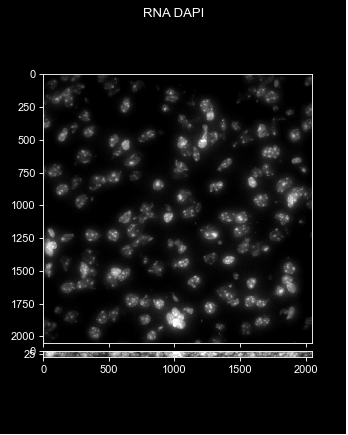

In [159]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_rna_dapi], min_max_default=[500,8000], image_names=['RNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_rna_dapi.png'), transparent=True)

In [84]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(12) as _seg_pool:
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 346.440s. 
Wall time: 5min 46s


## 2.2 Partition DNA-MERFISH spots

In [69]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [70]:
%%time
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
from ImageAnalysis3.io_tools.spots import FovCell2Spots_2_DataFrame
reload(segmentation_tools.cell)
reload(io_tools.spots)

genomic_library_bits = np.arange(1,100)

search_radius = 3
overwrite_cand_spots = False

_partition_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):

    
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', np.array([]))
    _align_seg._load(_total_seg_save_file)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    
    # load cand_spots_list
    with h5py.File(_save_filename, "r", libver='latest') as _f:
        _grp = _f['combo']
        combo_bits = _grp['ids'][:]
        
        sel_spots_list, sel_channels = [],[]
        for _bit in genomic_library_bits:
            _match_ind = np.where(combo_bits==_bit)[0]
            if len(_match_ind) > 0:
                _ind = _match_ind[0]
                _spots = _grp['spots'][_ind]
                sel_spots_list.append(_spots[_spots[:,0]>0])
                sel_channels.append(_grp['channels'][_ind].decode())
    # partition args
    _args = (
        _fov_id, seg_label, fovcell_2_uid, sel_spots_list, genomic_library_bits, sel_channels,
        _cand_spot_filename, search_radius, pixel_sizes,
        True, False, False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:81 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
-- loading segmentation info from fov:82 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
-- loading segmentation info from fov:83 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
-- loading segmentation info from fov:84 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
-- loading segmentation info from fov:85 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
-- loading segmentation info from fov:86 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
-- loading segmentation info from fov:87 into file: \\mendel\Men

In [71]:
%%time
from ImageAnalysis3.classes.partition_spots import _batch_partition_spots
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(12) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(_batch_partition_spots, _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 337.658s. 
Wall time: 5min 37s


# 3. Decoding of DNA-MERFISH

## 3.1 load codebook

In [72]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load spot files

In [73]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 test decode one cell

In [74]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
return_decoder = False
load_exist = True

pair_search_radius = 300

decode_args = []
for _fov_id, _save_filename in tqdm(zip(save_fov_ids, save_filenames)):
    
    #print(f"Prepare decoding args for fov: {_fov_id}")
    
    # load fov_df
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        
        if os.path.exists(_decoder_filename):
            continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, 
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 load_exist, overwrite_decoder, return_decoder, False) 
        # append
        decode_args.append(_args)

print(len(decode_args))

24it [01:25,  3.55s/it]

3081
Wall time: 1min 25s


In [47]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 0
decoder = decode.batch_decode_DNA(*decode_args[_cell_ind])

Creating DNA_Merfish_Decoder class.
- 9477 pairs kept given search radius 300 nm.
-- search spot_groups given search radius 300 nm, max_usage=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9477/9477 [00:00<00:00, 133378.81it/s]


- 2174 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
- Saving decoder into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-81_Cell-1_Decoder.hdf5
-- save cand_spots into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-81_Cell-1_Decoder.hdf5
-- save spot_groups into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-81_Cell-1_Decoder.hdf5


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'start', 'end',
       'chr'],
      dtype='object')]

  encoding=encoding,


-- save spot_groups into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-81_Cell-1_Decoder.hdf5
-- seeding chr:1 with 77 regions with 176 spot_groups
- diff in iter-0: 0.5852
- diff in iter-1: 0.0852
- diff in iter-2: 0.0000
-- seeding chr:10 with 51 regions with 114 spot_groups
- diff in iter-0: 0.5351
- diff in iter-1: 0.0175
- diff in iter-2: 0.0000
-- seeding chr:11 with 48 regions with 132 spot_groups
- diff in iter-0: 0.4773
- diff in iter-1: 0.0455
- diff in iter-2: 0.0000
-- seeding chr:12 with 43 regions with 115 spot_groups
- diff in iter-0: 0.5913
- diff in iter-1: 0.0261
- diff in iter-2: 0.0000
-- seeding chr:13 with 45 regions with 102 spot_groups
- diff in iter-0: 0.5980
- diff in iter-1: 0.0588
- diff in iter-2: 0.0196
- diff in iter-3: 0.0294
- diff in iter-4: 0.0000
-- seeding chr:14 with 42 regions with 103 spot_groups
- diff in iter-0: 0.5146
- diff in iter-1: 0.0583
- diff in iter-2: 0.0000
-- seeding chr:15 with 40 regions with 83 

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'e

-- save tuples for :chr_2_assigned_tuple_list/1/1
-- save tuples for :chr_2_assigned_tuple_list/10/0
-- save tuples for :chr_2_assigned_tuple_list/10/1


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  encoding=encoding,
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` 

-- save tuples for :chr_2_assigned_tuple_list/11/0
-- save tuples for :chr_2_assigned_tuple_list/11/1
-- save tuples for :chr_2_assigned_tuple_list/12/0


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', '

-- save tuples for :chr_2_assigned_tuple_list/12/1
-- save tuples for :chr_2_assigned_tuple_list/13/0
-- save tuples for :chr_2_assigned_tuple_list/13/1


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  encoding=encoding,
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` 

-- save tuples for :chr_2_assigned_tuple_list/14/0
-- save tuples for :chr_2_assigned_tuple_list/14/1
-- save tuples for :chr_2_assigned_tuple_list/15/0


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', '

-- save tuples for :chr_2_assigned_tuple_list/15/1
-- save tuples for :chr_2_assigned_tuple_list/16/0
-- save tuples for :chr_2_assigned_tuple_list/16/1


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  encoding=encoding,
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` 

-- save tuples for :chr_2_assigned_tuple_list/17/0
-- save tuples for :chr_2_assigned_tuple_list/17/1
-- save tuples for :chr_2_assigned_tuple_list/18/0


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 

-- save tuples for :chr_2_assigned_tuple_list/18/1
-- save tuples for :chr_2_assigned_tuple_list/19/0
-- save tuples for :chr_2_assigned_tuple_list/19/1
-- save tuples for :chr_2_assigned_tuple_list/2/0


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  encoding=encoding,
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` w

-- save tuples for :chr_2_assigned_tuple_list/2/1
-- save tuples for :chr_2_assigned_tuple_list/3/0
-- save tuples for :chr_2_assigned_tuple_list/3/1


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', '

-- save tuples for :chr_2_assigned_tuple_list/4/0
-- save tuples for :chr_2_assigned_tuple_list/4/1
-- save tuples for :chr_2_assigned_tuple_list/5/0


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', '

-- save tuples for :chr_2_assigned_tuple_list/5/1
-- save tuples for :chr_2_assigned_tuple_list/6/0
-- save tuples for :chr_2_assigned_tuple_list/6/1


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  encoding=encoding,
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` w

-- save tuples for :chr_2_assigned_tuple_list/7/0
-- save tuples for :chr_2_assigned_tuple_list/7/1
-- save tuples for :chr_2_assigned_tuple_list/8/0


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', '

-- save tuples for :chr_2_assigned_tuple_list/8/1
-- save tuples for :chr_2_assigned_tuple_list/9/0
-- save tuples for :chr_2_assigned_tuple_list/9/1


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  encoding=encoding,
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` w

-- save tuples for :chr_2_assigned_tuple_list/X/0
-- save tuples for :chr_2_assigned_tuple_list/X/1
- Update chr_2_indices_list into \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-81_Cell-1_Decoder.hdf5
-- saving 1 in chr_2_indices_list
-- saving 10 in chr_2_indices_list
-- saving 11 in chr_2_indices_list
-- saving 12 in chr_2_indices_list
-- saving 13 in chr_2_indices_list
-- saving 14 in chr_2_indices_list
-- saving 15 in chr_2_indices_list
-- saving 16 in chr_2_indices_list
-- saving 17 in chr_2_indices_list
-- saving 18 in chr_2_indices_list
-- saving 19 in chr_2_indices_list
-- saving 2 in chr_2_indices_list
-- saving 3 in chr_2_indices_list
-- saving 4 in chr_2_indices_list
-- saving 5 in chr_2_indices_list
-- saving 6 in chr_2_indices_list
-- saving 7 in chr_2_indices_list
-- saving 8 in chr_2_indices_list
-- saving 9 in chr_2_indices_list
-- saving X in chr_2_indices_list
- Update chr_2_zxys_list into \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brai

### decoder

## visualize decoded spots

In [172]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests
Use decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\Figures


In [ ]:
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               #cmap=Spectral, 
               color=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

## 3.4 process all

In [75]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

3081
Wall time: 1h 8min 21s
